In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage import io
from PIL import Image, ImageOps
import math
from scipy.spatial import distance_matrix


In [73]:
red_img = cv2.cvtColor(cv2.imread("images/colors/red.png"),cv2.COLOR_BGR2RGB)
orange_img = cv2.cvtColor(cv2.imread("images/colors/orange.png"),cv2.COLOR_BGR2RGB)
white_img = cv2.cvtColor(cv2.imread("images/colors/white.png"),cv2.COLOR_BGR2RGB)
yellow_img = cv2.cvtColor(cv2.imread("images/colors/yellow.png"),cv2.COLOR_BGR2RGB)
green_img = cv2.cvtColor(cv2.imread("images/colors/green.png"),cv2.COLOR_BGR2RGB)
blue_img = cv2.cvtColor(cv2.imread("images/colors/blue.png"),cv2.COLOR_BGR2RGB)

In [79]:
RUBIKS_COLORS = {
    "Red": red_img.mean(axis=(0,1)),
    "Blue": blue_img.mean(axis=(0,1)),
    "Green": green_img.mean(axis=(0,1)),
    "Yellow": yellow_img.mean(axis=(0,1)),
    "White": white_img.mean(axis=(0,1)),
    "Orange": orange_img.mean(axis=(0,1))
}

print(RUBIKS_COLORS)

{'Red': array([103.44083333,   2.21837719,  17.38381579]), 'Blue': array([ 0.        , 45.15311404, 76.44074561]), 'Green': array([ 66.34087719, 121.01337719,  35.74460526]), 'Yellow': array([152.82017544, 137.70175439,  17.21635965]), 'White': array([153.23245614, 143.72504386, 128.03333333]), 'Orange': array([218.07289474,  68.74855263,  31.77561404])}


In [80]:
def display_image(img):
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title('Image')
    plt.axis('off')
    plt.show()

In [81]:
def canny_edge_detector(img):
     edges = cv2.Canny(img, 50, 150)
     return edges


def draw_hough_lines(img, lines):
    """Draws Hough lines on top of the original image."""
    black_image = np.zeros_like(img)

    
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(black_image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green lines
    
    return black_image



In [82]:
def get_hough_lines(edges):
    """Detects lines using Hough Transform."""
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=20, minLineLength=10, maxLineGap=10)
    return lines



In [83]:
def find_corners(image):
    target_color = np.array([0, 255, 0])  # Example: Pure Red

    # Find all pixels matching the target color
    matches = np.all(image == target_color, axis=-1)

    # Get the coordinates of matching pixels
    coordinates = np.column_stack(np.where(matches))  # (y, x) format


    # Find the top-left and bottom-right coordinates
    top_left = tuple(coordinates.min(axis=0)[::-1])  # Swap (y, x) -> (x, y)
    bottom_right = tuple(coordinates.max(axis=0)[::-1])

    print(f"Top-left most pixel: {top_left}")
    print(f"Bottom-right most pixel: {bottom_right}")
    return top_left, bottom_right



In [84]:
def kmeans_color(img, k=1):
    """Apply KMeans clustering to find the dominant color in an image region."""
    pixels = img.reshape(-1, 3)  # Flatten the region into a 2D array
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(pixels)
    dominant_color = kmeans.cluster_centers_.astype(int)  # Get cluster center (average color)
    return dominant_color[0]  # Return the dominant color
def closest_rubiks_color(color):
    """Find the closest Rubik's Cube color based on Euclidean distance."""
    distances = {name: np.linalg.norm(color - rgb) for name, rgb in RUBIKS_COLORS.items()}
    return min(distances, key=distances.get)

def split_and_kmeans(image_path, top_left, bottom_right):
    """Splits a region of an image into a 3x3 grid and finds the closest Rubik's Cube color for each region."""
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    
    x1, y1 = top_left
    x2, y2 = bottom_right
    
    # Extract region
    region = image[y1:y2, x1:x2]
    h, w, _ = region.shape

    # Determine grid size
    grid_h, grid_w = h // 3, w // 3

    # Store colors
    colors = []
    color_names = []

    # Process each 3x3 subregion
    for i in range(3):
        row_colors = []
        row_names = []
        for j in range(3):
            x_start, y_start = j * grid_w, i * grid_h
            x_end, y_end = x_start + grid_w, y_start + grid_h

            subregion = region[y_start:y_end, x_start:x_end]
            dominant_color = kmeans_color(subregion)
            closest_color = closest_rubiks_color(dominant_color)
            row_colors.append(RUBIKS_COLORS[closest_color])  # Save actual RGB color
            row_names.append(closest_color)  # Save color name
        
        colors.append(row_colors)
        color_names.append(row_names)

    return colors, color_names


In [ ]:
image = cv2.imread("images/img8.jpg")
edges = canny_edge_detector(image)
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=10, minLineLength=25, maxLineGap=10)
hough_line_image = draw_hough_lines(image, lines)

top_left, bottom_right = find_corners(hough_line_image)
print("top_left", top_left)
print("bottom_right", bottom_right)
# print(image.shape)
unique_colors = np.unique(image.reshape(-1, 3), axis=0)
print(unique_colors)
print("about to show image")
cv2.imshow('image', hough_line_image)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

Top-left most pixel: (np.int64(593), np.int64(1137))
Bottom-right most pixel: (np.int64(2349), np.int64(2765))
top_left (np.int64(593), np.int64(1137))
bottom_right (np.int64(2349), np.int64(2765))
[[  0   0   0]
 [  0   0   1]
 [  0   0   3]
 ...
 [255 255 239]
 [255 255 240]
 [255 255 241]]
about to show image


-1

In [88]:
colors, color_names = split_and_kmeans("images/img8.jpg", top_left, bottom_right)
print(color_names)

cv2.imshow('image', image)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)




[['Green', 'White', 'Red'], ['Red', 'Orange', 'White'], ['White', 'Red', 'Orange']]


-1

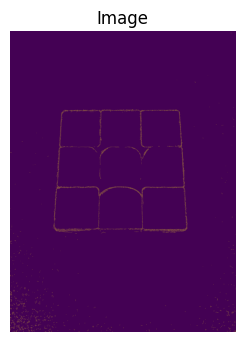

In [67]:
display_image(edges)